Erick Badillo - 741550
Leafs classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

###Inicialización de variables globales

In [3]:
import torchvision.transforms as transforms

dataset_path = '/content/drive/MyDrive/Colab Notebooks/dl/leafs-dataset'

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
import os

def eliminar_archivos_vacios(root_dir):
    archivos_vacios = 0
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            if os.path.getsize(filepath) == 0:
                archivos_vacios += 1
                os.remove(filepath)
    return archivos_vacios

archivos_eliminados = eliminar_archivos_vacios(dataset_path)
print(f'{archivos_eliminados} archivos vacíos eliminados.')

0 archivos vacíos eliminados.


In [5]:
import os

def rename_directories_to_lowercase(root_dir):
    for name in os.listdir(root_dir):
        original_path = os.path.join(root_dir, name)
        if os.path.isdir(original_path):
            lowercase_path = os.path.join(root_dir, name.lower())
            if original_path != lowercase_path:
                os.rename(original_path, lowercase_path)

rename_directories_to_lowercase(dataset_path)

###Declaración de funciones de utileria para inspeccionar el dataset

In [6]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset
from collections import Counter
from random import sample

class LeafSpeciesDataset(Dataset):
    def __init__(self, root_dir, transform=None, subset=None):
        self.root_dir = root_dir
        self.transform = transform
        self.subset = subset
        self.samples, self.category_counts = self._load_samples()
        self.species_to_idx = {species: idx for idx, species in enumerate(self.category_counts)}

    def _load_samples(self):
      all_samples = {}
      category_counts = Counter()

      for folder_name in os.listdir(self.root_dir):
          folder_path = os.path.join(self.root_dir, folder_name)
          leaf_specie = folder_name.split('___')[0].lower()
          for img_name in os.listdir(folder_path):
              img_path = os.path.join(folder_path, img_name)
              if leaf_specie not in all_samples:
                  all_samples[leaf_specie] = []
              all_samples[leaf_specie].append((img_path, leaf_specie))

      samples = []
      for specie, specie_samples in all_samples.items():
          if self.subset and len(specie_samples) > self.subset:
              sampled_images = sample(specie_samples, self.subset)
          else:
              sampled_images = specie_samples
          samples.extend(sampled_images)
          category_counts[specie] = len(sampled_images)

      return samples, category_counts

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, species = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        one_hot = torch.zeros(len(self.category_counts))
        one_hot[self.species_to_idx[species]] = 1

        return img, species, one_hot

    def get_category_counts(self):
        return self.category_counts

    def get_species_to_idx(self):
      return self.species_to_idx

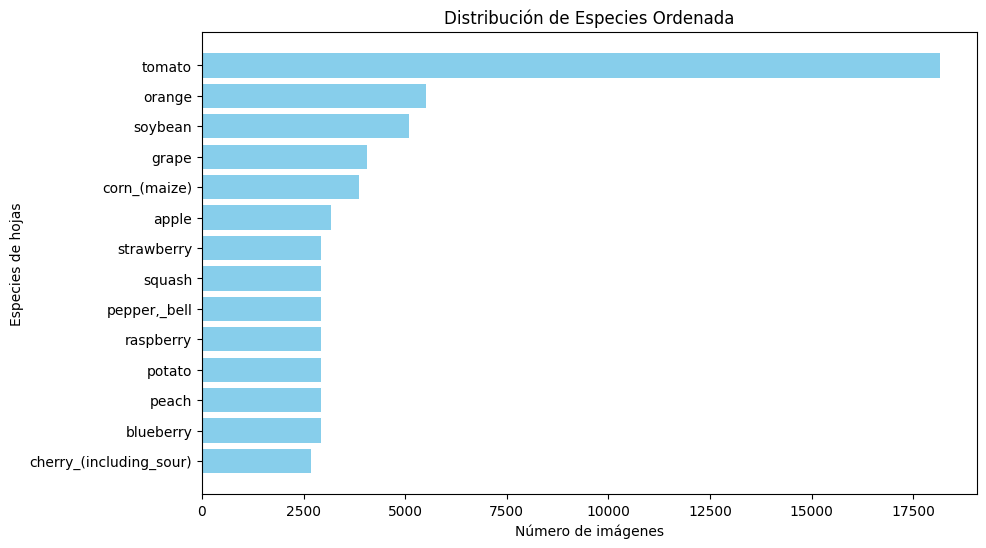

In [7]:
import matplotlib.pyplot as plt

leafs_dataset = LeafSpeciesDataset(root_dir=dataset_path, transform=transformations, subset=None)
leaf_species_counts = leafs_dataset.get_category_counts()

# Ordenar las categorías por número de muestras (de menor a mayor)
sorted_species_counts = {k: v for k, v in sorted(leaf_species_counts.items(), key=lambda item: item[1])}

leaf_species = list(sorted_species_counts.keys())
leafs_by_specie = list(sorted_species_counts.values())

plt.figure(figsize=(10, 6))
plt.barh(leaf_species, leafs_by_specie, color='skyblue')
plt.ylabel('Especies de hojas')
plt.xlabel('Número de imágenes')
plt.title('Distribución de Especies Ordenada')
plt.show()


In [8]:
for species, count in leaf_species_counts.items():
    print(f"Especie: {species}, Número de muestras: {count}")

Especie: apple, Número de muestras: 3171
Especie: blueberry, Número de muestras: 2931
Especie: grape, Número de muestras: 4062
Especie: peach, Número de muestras: 2931
Especie: potato, Número de muestras: 2931
Especie: raspberry, Número de muestras: 2931
Especie: soybean, Número de muestras: 5084
Especie: tomato, Número de muestras: 18155
Especie: cherry_(including_sour), Número de muestras: 2685
Especie: corn_(maize), Número de muestras: 3852
Especie: orange, Número de muestras: 5507
Especie: pepper,_bell, Número de muestras: 2931
Especie: squash, Número de muestras: 2931
Especie: strawberry, Número de muestras: 2931


In [9]:
relevant_leaf_species = ['apple', 'pepper,_bell', 'grape', 'cherry_(including_sour)', 'potato', 'corn_(maize)', 'peach']
total_relevant_leafs = 0

for species, count in leaf_species_counts.items():
    if species in relevant_leaf_species:
        total_relevant_leafs += count

average = total_relevant_leafs / len(relevant_leaf_species) if relevant_leaf_species else 0

print(f"Total de hojas relevantes: {total_relevant_leafs}")
print(f"Promedio de hojas por especie relevante: {average}")

Total de hojas relevantes: 22563
Promedio de hojas por especie relevante: 3223.285714285714


In [10]:
synthetic_requirements = Counter()
for species, count in leaf_species_counts.items():
  synthetic_required_data = average - count
  synthetic_requirements[species] = 0
  if synthetic_required_data > 0:
    synthetic_requirements[species] = int(synthetic_required_data)

for species, count in synthetic_requirements.items():
  print(f'{count} imagenes requeridas por la Especie {species}')

52 imagenes requeridas por la Especie apple
292 imagenes requeridas por la Especie blueberry
0 imagenes requeridas por la Especie grape
292 imagenes requeridas por la Especie peach
292 imagenes requeridas por la Especie potato
292 imagenes requeridas por la Especie raspberry
0 imagenes requeridas por la Especie soybean
0 imagenes requeridas por la Especie tomato
538 imagenes requeridas por la Especie cherry_(including_sour)
0 imagenes requeridas por la Especie corn_(maize)
0 imagenes requeridas por la Especie orange
292 imagenes requeridas por la Especie pepper,_bell
292 imagenes requeridas por la Especie squash
292 imagenes requeridas por la Especie strawberry


In [11]:
import os
import random
import uuid
from PIL import Image
import torchvision.transforms as transforms

class SyntheticDataGenerator:
    def __init__(self, root_dir, output_dir):
        self.root_dir = root_dir
        self.output_dir = output_dir

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter()
        ])

    def _load_images_from_class(self, class_name):
        class_path = ''
        class_path_healthy = os.path.join(self.root_dir, class_name + '___healthy')

        if os.path.exists(class_path_healthy):
            class_path = class_path_healthy
        else:
            for folder_name in os.listdir(self.root_dir):
                if folder_name.lower().startswith(class_name):
                    class_path = os.path.join(self.root_dir, folder_name)
                    break
            else:
                return []

        images = []
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            images.append(img_path)
        return images


    def BalanceClass(self, class_name, num_synthetic_images):
        images = self._load_images_from_class(class_name)

        if(len(images) == 0):
            return

        for _ in range(num_synthetic_images):
            img_path = random.choice(images)
            img = Image.open(img_path).convert('RGB')

            synthetic_output_path = os.path.join(self.output_dir, f"{class_name}___healthy_synthetic")
            if not os.path.exists(synthetic_output_path):
                os.makedirs(synthetic_output_path)

            filename = f"{uuid.uuid4()}.jpg"

            synthetic_img = self.transform(img)
            synthetic_img.save(os.path.join(synthetic_output_path, f"{filename}"))


In [31]:
generator = SyntheticDataGenerator(root_dir=dataset_path, output_dir=dataset_path)
for category, additional_needed in synthetic_requirements.items():
    if additional_needed > 0:
        generator.BalanceClass(category, num_synthetic_images=additional_needed)

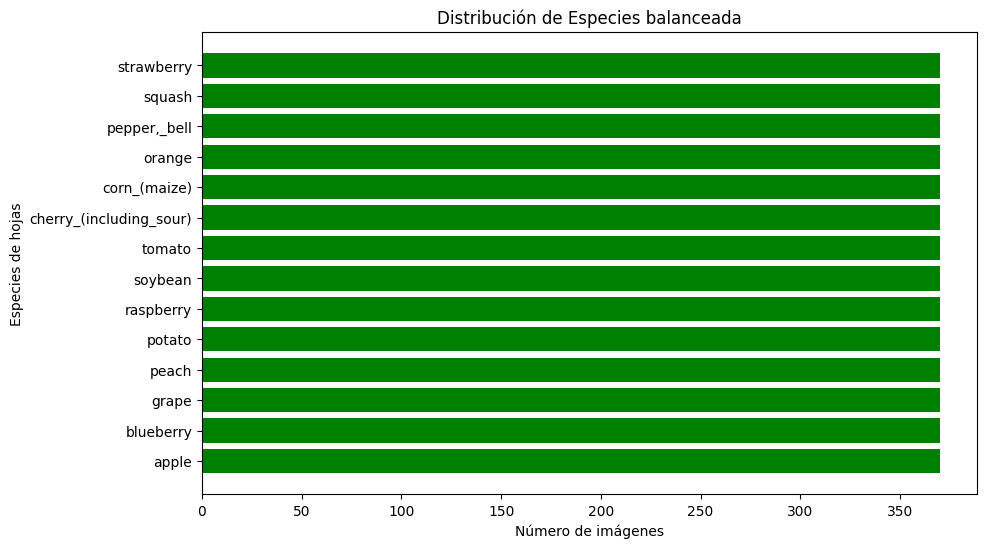

In [12]:
average = 370
balanced_leafs_dataset = LeafSpeciesDataset(root_dir=dataset_path, transform=transformations, subset=int(average))
leafs_balanced_counts = balanced_leafs_dataset.get_category_counts()

leaf_balanced_species = list(leafs_balanced_counts.keys())
leafs_balanced_by_specie = list(leafs_balanced_counts.values())

plt.figure(figsize=(10, 6))
plt.barh(leaf_balanced_species, leafs_balanced_by_specie, color='green')
plt.ylabel('Especies de hojas')
plt.xlabel('Número de imágenes')
plt.title('Distribución de Especies balanceada')
plt.show()

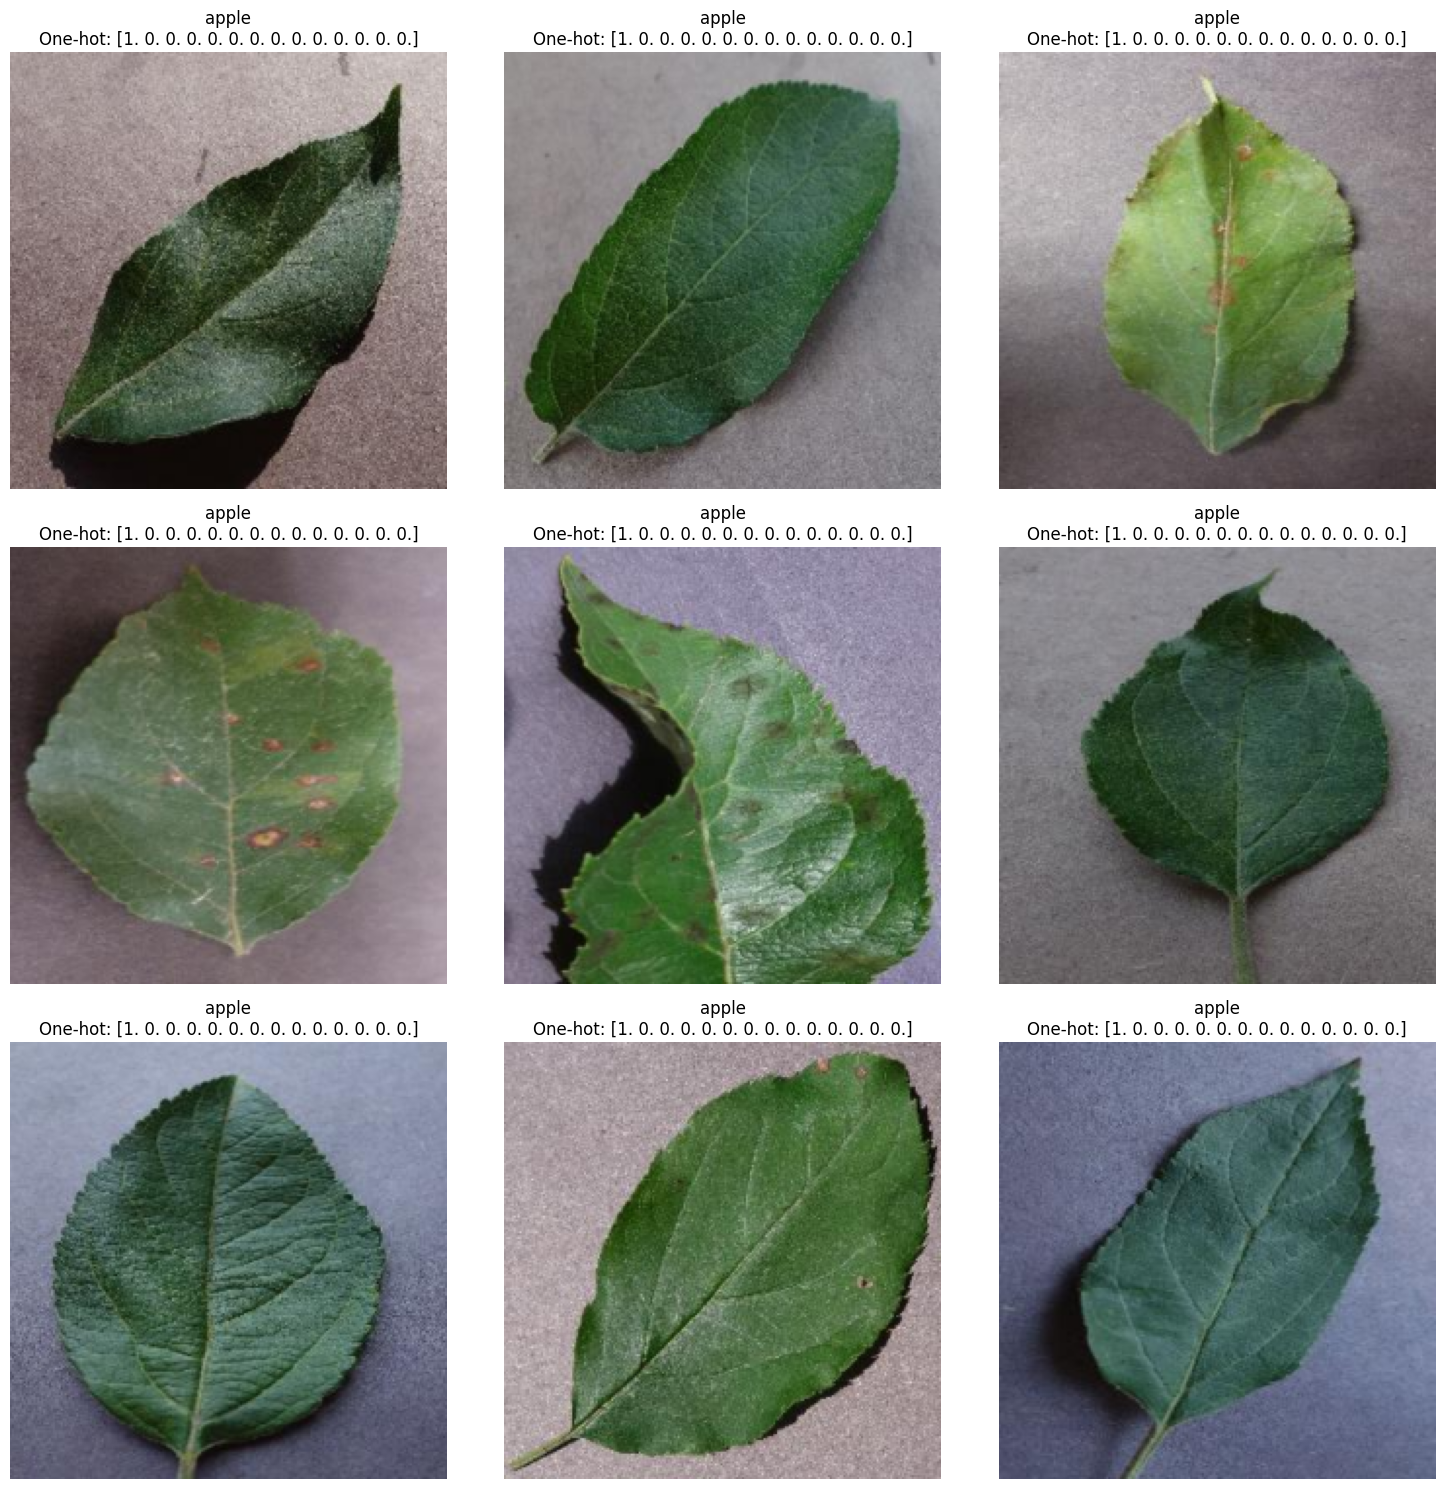

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

selected_samples = []

for img, species, one_hot in balanced_leafs_dataset:
    selected_samples.append((img, species, one_hot))
    if len(selected_samples) == 9:
        break

num_samples = len(selected_samples)
num_cols = 3
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, (img, species, one_hot) in enumerate(selected_samples):
    if img.shape[0] == 3:  # Verificar si el tensor de imagen es CxHxW
        img = img.permute(1, 2, 0)  # Convertir a HxWxC para la visualización
    axes[i].imshow(img)
    axes[i].set_title(f"{species}\nOne-hot: {one_hot.numpy()}")
    axes[i].axis('off')

for ax in axes[len(selected_samples):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [14]:
total_size = len(balanced_leafs_dataset)

train_size = int(0.80 * total_size)
val_size = int(total_size - train_size)
test_size = int(0.02 * val_size)
val_size = val_size - test_size

print(f'Total: {total_size}, Entrenamiento: {train_size}, Validacion: {val_size}, Test: {test_size}')

Total: 5180, Entrenamiento: 4144, Validacion: 1016, Test: 20


In [15]:
from torch.utils.data import random_split
train_dataset, val_dataset, test_dataset = random_split(balanced_leafs_dataset, [train_size, val_size, test_size])

In [16]:
from torch.utils.data import DataLoader

batch_size = 40

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class MyResNet18_LeafSpecieClassification(nn.Module):
    def __init__(self, block, layers, num_classes=14):
        super(MyResNet18_LeafSpecieClassification, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def my_resnet18_leafSpecieClassification(num_classes=14):
    return MyResNet18_LeafSpecieClassification(BasicBlock, [2, 2, 2, 2], num_classes)

In [18]:
from torchsummary import summary
summary(my_resnet18_leafSpecieClassification().to('cuda'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [19]:
def fit(model, train_loader, val_loader, epochs, optimizer, loss_fn, checkpoint_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, _, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, _, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += loss_fn(outputs, labels).item()

        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model improved and saved to {checkpoint_path}')

In [20]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

classification_model = my_resnet18_leafSpecieClassification()
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)
loss_fn = F.cross_entropy
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/dl/leafs_model/leaf_specie_clmodel"

fit(classification_model, train_loader, val_loader, epochs=10, optimizer=optimizer, loss_fn=loss_fn, checkpoint_path=checkpoint_path)

Epoch 1/10, Training Loss: 1.5838
Epoch 1/10, Validation Loss: 2.1850
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/leaf_specie_clmodel
Epoch 2/10, Training Loss: 0.9845
Epoch 2/10, Validation Loss: 1.3664
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/leaf_specie_clmodel
Epoch 3/10, Training Loss: 0.7745
Epoch 3/10, Validation Loss: 0.9813
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/leaf_specie_clmodel
Epoch 4/10, Training Loss: 0.6475
Epoch 4/10, Validation Loss: 0.8516
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/leaf_specie_clmodel
Epoch 5/10, Training Loss: 0.5317
Epoch 5/10, Validation Loss: 1.3725
Epoch 6/10, Training Loss: 0.4337
Epoch 6/10, Validation Loss: 1.0124
Epoch 7/10, Training Loss: 0.4206
Epoch 7/10, Validation Loss: 0.6641
Model improved and saved to /content/drive/MyDrive/Colab Notebooks/dl/leafs_model/leaf_specie_clmodel


In [21]:
def test(model, test_loader, loss_fn):
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for inputs, _, targets in test_loader:

            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            # Convertir los logits a probabilidades y obtener la clase predicha
            probabilities = F.softmax(outputs, dim=1)

            _, predicted = torch.max(probabilities, 1)
            _, targets = torch.max(targets, 1)

            print("Outputs shape:", outputs.shape)
            print("Probabilities shape:", probabilities.shape)
            print("Predicted shape:", predicted.shape)
            print("Targets shape:", targets.shape)

            # Contar las predicciones correctas
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Calcular la precisión total
    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)  # Calcular la pérdida media del test set (opcional)
    return avg_loss, accuracy

In [22]:
# Cargar el modelo entrenado
pretrain_model = my_resnet18_leafSpecieClassification()
pretrain_model.load_state_dict(torch.load(checkpoint_path))
pretrain_model.to('cuda')

MyResNet18_LeafSpecieClassification(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [23]:
test_loss, test_accuracy = test(pretrain_model, test_loader, loss_fn)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}')

Outputs shape: torch.Size([20, 14])
Probabilities shape: torch.Size([20, 14])
Predicted shape: torch.Size([20])
Targets shape: torch.Size([20])
Test Loss: 1.1782, Test Accuracy: 0.60


In [25]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def classify_leaf_specie(image_path, model, classes):
    transformations = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('RGB')
    transformed_image = transformations(image).unsqueeze(0).to('cuda')

    model.eval()
    with torch.no_grad():
        output = model(transformed_image)

    probabilities = torch.nn.functional.softmax(output, dim=1)
    _, pred_idx = torch.max(probabilities, 1)

    predicted_species = classes[pred_idx.item()]

    return predicted_species


In [26]:
tomato_example_file = 'tomato___healthy/00bce074-967b-4d50-967a-31fdaa35e688___RS_HL 0223.JPG'
tomato_path = os.path.join(dataset_path, tomato_example_file)
classes = {v: k for k, v in balanced_leafs_dataset.get_species_to_idx().items()}

specie = classify_leaf_specie(tomato_path, pretrain_model, classes)
print(specie)

tomato
